# Jupyter Notebook of the SC-seq analsyis done with SCANPY & CellO, using chicken neck skin data

This is the script that performs the CS-seq analysis using SCANPY and CellO. Made by Laurens-Willem Janssen. Started on March 31 2023, finished on July 3 2023. Guides used: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html & https://github.com/deweylab/CellO/blob/package_for_pypi/tutorial/cello_tutorial.ipynb



Five packages are used for everything in the notebook; AnnData, SCANPY, Pandas, NumPy and CellO.

In [1]:
from anndata import AnnData
import scanpy as sc
import pandas as pd
import numpy as np
import cello

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.8


Read in the Cell Ranger data.

In [3]:
celloob = sc.read_10x_mtx('Downloads/filtered_feature_bc_matrixN/', var_names='gene_ids', cache=True)

... reading from cache file cache\Downloads-filtered_feature_bc_matrixN-matrix.h5ad


Because the markers for mitochondrial genes were not present in the start data, it had to be added manually to the mitochondrial gene names.

In [4]:
mtlist = ("ND1", "ND2", "COX1", "COX2", "ATP8", "ATP6", "COX3",
          "ND3", "ND4L", "ND4", "ND5", "CYTB", "ND6")
var_count = 0
Newvarnames = []
for x in celloob.var_names:
    xx = x
    for y in mtlist:
        if x[:len(y)] == y:
            xx = 'MT-' + x
    Newvarnames.append(xx)       
    var_count += 1
celloob.var_names = Newvarnames
celloob.var['mt'] = celloob.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(celloob, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

CellO requires 3000 of the input genes to be known in its database, and in order to reach that no filtering on low/high expression could occur. The process goes straight to normalization and log-transformation.

In [5]:
sc.pp.normalize_total(celloob, target_sum=1e4)
sc.pp.log1p(celloob)

normalizing counts per cell
    finished (0:00:00)


The next steps are selecting for highly variable genes, PCA, neighbors calculation and Leiden clustering

In [6]:
#Identifying highly variable genes
sc.pp.highly_variable_genes(celloob, n_top_genes=10000, min_mean=0.0125, max_mean=3, min_disp=0.5)
celloob = celloob[:, celloob.var.highly_variable]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [7]:
#Performing PCA
sc.tl.pca(celloob, svd_solver='arpack', n_comps=25, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=25
    finished (0:00:02)


In [8]:
#Neighbour calculation
sc.pp.neighbors(celloob, use_rep='X', n_neighbors=15)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:51)


After trial and error, a resolution of 0.9 was determined to have generated the best clutering result.

In [9]:
#Clustering with a resolution of 0.9
sc.tl.leiden(celloob, resolution=0.9)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


The start of the cell type annotation process with CellO is locating the CellO dataset that had to be downloaded seperately. The verbosity will be set one degree lower, as CellO comments on every label that fininshed training.

In [10]:
#Stating the location of the CellO dataset
cello_resource_loc = 'C:\\Users\\bestb\\anaconda3\\Lib\\site-packages'

In [11]:
#Run CellO
sc.settings.verbosity = 0
cello.scanpy_cello(celloob, 'leiden', cello_resource_loc, out_prefix="modelprefix")

Found CellO resources at 'C:\Users\bestb\anaconda3\Lib\site-packages\resources'.
Checking if any pre-trained model is compatible with this input dataset...


C:\Users\bestb\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\bestb\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Could not find compatible pre-trained model.
Found CellO resources at 'C:\Users\bestb\anaconda3\Lib\site-packages\resources'.
Loading ontology...
Loading expression data from C:\Users\bestb\anaconda3\Lib\site-packages\resources\training_set\log_tpm.h5...
Loaded matrix of shape (4293, 58243)
done.
Inferred that input file uses HGNC gene symbols.
Of 10000 genes in the input file, 6080 were found in the training set of 58243 genes.
Training model...
Fitting PCA with 3000 components...
done.
Transforming with PCA...
done.
(1/317)
Training classifier for label CL:0000576...
Number of positive items: 314
Number of negative items: 3950
(2/317)
Training classifier for label CL:0002087...
Number of positive items: 2010
Number of negative items: 2267
(3/317)
Training classifier for label CL:2000001...
Number of positive items: 1575
Number of negative items: 2242
(4/317)
Training classifier for label CL:0000842...
Number of positive items: 2010
Number of negative items: 2267
(5/317)
Training clas

(70/317)
Training classifier for label CL:0000625...
Number of positive items: 131
Number of negative items: 4048
(71/317)
Training classifier for label CL:0000897...
Number of positive items: 136
Number of negative items: 3897
(72/317)
Training classifier for label CL:0000813...
Number of positive items: 185
Number of negative items: 3994
(73/317)
Training classifier for label CL:0000864...
Number of positive items: 83
Number of negative items: 4166
(74/317)
Training classifier for label CL:0000583...
Number of positive items: 26
Number of negative items: 4223
(75/317)
Training classifier for label CL:0000895...
Number of positive items: 53
Number of negative items: 3978
(76/317)
Training classifier for label CL:0000898...
Number of positive items: 71
Number of negative items: 4108
(77/317)
Training classifier for label CL:0001062...
Number of positive items: 8
Number of negative items: 4110
(78/317)
Training classifier for label CL:0000909...
Number of positive items: 48
Number of ne

(143/317)
Training classifier for label CL:0000171...
Number of positive items: 23
Number of negative items: 4127
(144/317)
Training classifier for label CL:0002067...
Number of positive items: 23
Number of negative items: 4127
(145/317)
Training classifier for label CL:0000055...
Number of positive items: 43
Number of negative items: 4250
(146/317)
Training classifier for label CL:0000062...
Number of positive items: 31
Number of negative items: 4251
(147/317)
Training classifier for label CL:0002174...
Number of positive items: 41
Number of negative items: 4228
(148/317)
Training classifier for label CL:0000501...
Number of positive items: 15
Number of negative items: 4246
(149/317)
Training classifier for label CL:0000174...
Number of positive items: 15
Number of negative items: 4268
(150/317)
Training classifier for label CL:0002038...
Number of positive items: 15
Number of negative items: 4015
(151/317)
Training classifier for label CL:1000272...
Number of positive items: 5
Number

(216/317)
Training classifier for label CL:0002321...
Number of positive items: 35
Number of negative items: 4252
(217/317)
Training classifier for label CL:0000670...
Number of positive items: 23
Number of negative items: 4261
(218/317)
Training classifier for label CL:0000049...
Number of positive items: 11
Number of negative items: 4188
(219/317)
Training classifier for label CL:0002536...
Number of positive items: 4
Number of negative items: 4265
(220/317)
Training classifier for label CL:0002631...
Number of positive items: 20
Number of negative items: 4026
(221/317)
Training classifier for label CL:0002090...
Number of positive items: 4
Number of negative items: 4283
(222/317)
Training classifier for label CL:0000971...
Number of positive items: 1
Number of negative items: 4115
(223/317)
Training classifier for label CL:0001053...
Number of positive items: 1
Number of negative items: 4115
(224/317)
Training classifier for label CL:0000972...
Number of positive items: 5
Number of 

(289/317)
Training classifier for label CL:2000095...
Number of positive items: 2
Number of negative items: 3772
(290/317)
Training classifier for label CL:1001599...
Number of positive items: 2
Number of negative items: 4259
(291/317)
Training classifier for label CL:0000152...
Number of positive items: 2
Number of negative items: 4283
(292/317)
Training classifier for label CL:1001433...
Number of positive items: 2
Number of negative items: 4267
(293/317)
Training classifier for label CL:0000123...
Number of positive items: 1
Number of negative items: 4284
(294/317)
Training classifier for label CL:0000242...
Number of positive items: 1
Number of negative items: 4264
(295/317)
Training classifier for label CL:0000810...
Number of positive items: 2
Number of negative items: 4177
(296/317)
Training classifier for label CL:0000811...
Number of positive items: 2
Number of negative items: 4177
(297/317)
Training classifier for label CL:0000128...
Number of positive items: 5
Number of nega

C:\Users\bestb\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\bestb\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Of 10000 genes in the input file, 6080 were found in the training set of 58243 genes.
Of 10000 genes in the input file, 6016 were found in the training set of 31283 genes.
Using thresholds stored in C:\Users\bestb\anaconda3\Lib\site-packages\resources\trained_models\ir.10x_genes_thresholds.tsv
Binarizing classifications...
Mapping each sample to its predicted labels...
Computing the most-specific predicted labels...
Loading ontology...
Item 0 predicted to be "type II pneumocyte (CL:0002063)"
Item 1 predicted to be "surfactant secreting cell (CL:0000157)"
Item 10 predicted to be "keratinocyte (CL:0000312)"
Item 11 predicted to be "precursor cell (CL:0011115)"
Item 12 predicted to be "epidermal cell (CL:0000362)"
Item 2 predicted to be "somatic cell (CL:0002371)"
Item 3 predicted to be "connective tissue cell (CL:0002320)"
Item 4 predicted to be "somatic cell (CL:0002371)"
Item 5 predicted to be "columnar/cuboidal epithelial cell (CL:0000075)"
Item 6 predicted to be "neurecto-epithelial 

Following CellO, the UMAP can now be calculated, allowing for the visualization of the generated clusters.

In [12]:
#Calculate UMAP
sc.settings.verbosity = 3
sc.tl.umap(celloob)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


... storing 'Most specific cell type' as categorical
... storing 'feature_types' as categorical


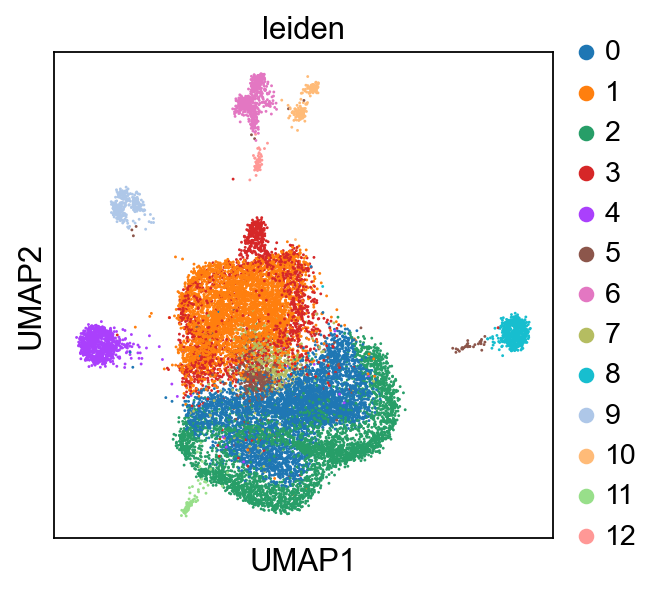

In [13]:
#Create the Cluster UMAP plot.
sc.pl.umap(celloob, color="leiden")

The heatmap was made using the 25 genes with the highest mean count value over the whole dataset.

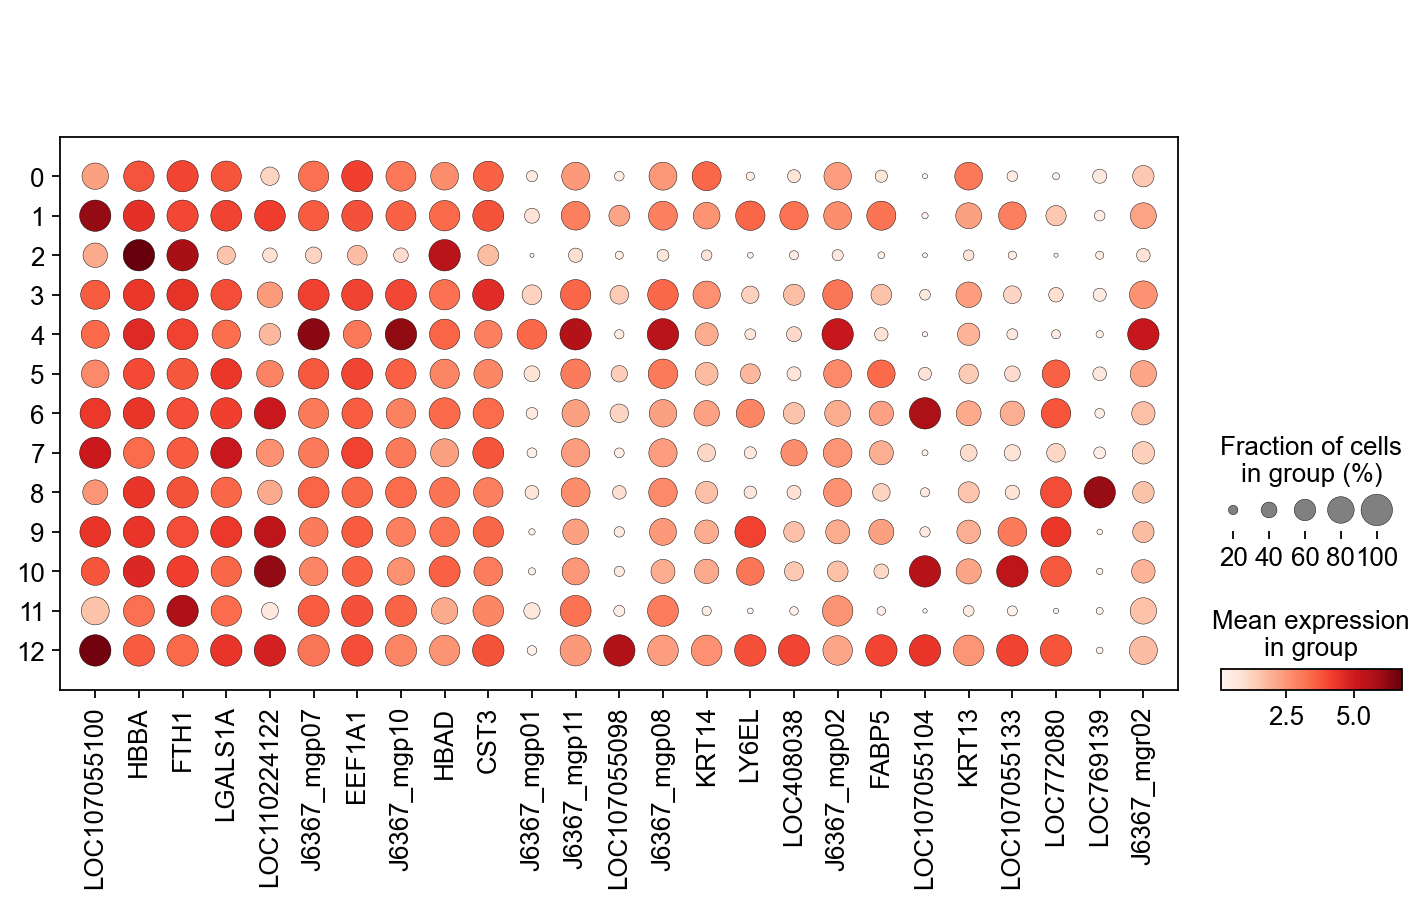

In [14]:
#Create the heatmap
celloob.var.sort_values('mean_counts').gene_symbols.tail(25)
top10meancount = ['LOC107055100', 'HBBA', 'FTH1', 'LGALS1A', 'LOC110224122',
                  'J6367_mgp07', 'EEF1A1', 'J6367_mgp10', 'HBAD', 'CST3',
                 'J6367_mgp01', 'J6367_mgp11' ,'LOC107055098', 'J6367_mgp08',
                 'KRT14', 'LY6EL', 'LOC408038', 'J6367_mgp02', 'FABP5', 'LOC107055104',
                 'KRT13', 'LOC107055133', 'LOC772080', 'LOC769139', 'J6367_mgr02']
sc.pl.dotplot(celloob, top10meancount, groupby='leiden')

The UMAP showing the most specific cell type for each cluster.

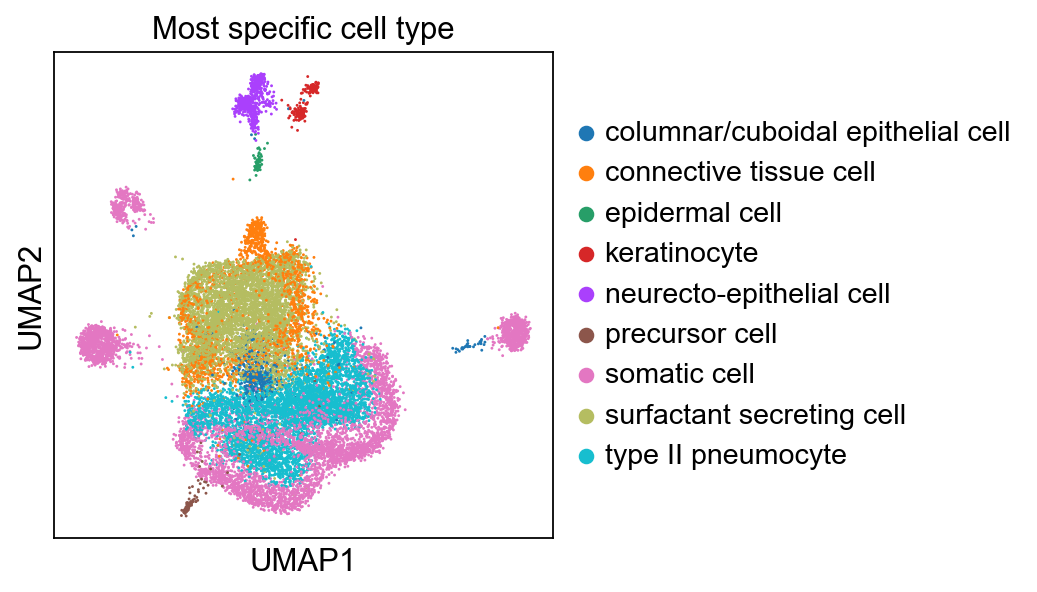

In [15]:
sc.pl.umap(celloob, color='Most specific cell type')